In [16]:
import os

# import sys
# sys.path.append(os.path.abspath("/app/utils"))

from utils.helper import *
from utils.dataProcess import *
from datetime import datetime,timedelta
import open3d as o3d
from scipy.io import savemat
from concurrent.futures import ProcessPoolExecutor


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import concurrent.futures
from utils.helper import *
import gc
import time
from tqdm import tqdm
from tqdm.notebook import tqdm
tqdm.pandas()

In [3]:
#defining the folder to strore the for every session 
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
processedDataFolder_name = f"./processedData/{timestamp}/"
depVis = processedDataFolder_name + "visualization/depth/"
radVis = processedDataFolder_name + "visualization/radar/"
merRadDepVis = processedDataFolder_name + "visualization/RadarDepth/"
merRadDepVisdownSample = processedDataFolder_name + "visualization/downSampledRadarDepth/"
# Check if the folder exists, if not, create it
if not os.path.exists(processedDataFolder_name):
    os.makedirs(processedDataFolder_name)
    os.makedirs(depVis)
    os.makedirs(radVis)
    os.makedirs(merRadDepVis)
    os.makedirs(merRadDepVisdownSample)
    print(f"Folder '{processedDataFolder_name}' created.")
else:
    print(f"Folder '{processedDataFolder_name}' already exists.")

Folder './processedData/2025-02-01_20-37-53/' created.


In [4]:

def density_based_downsampling(pcd, target_num_points,voxelSize):
    """
    Perform density-based downsampling using voxel grid filtering.

    Args:
        pcd (open3d.geometry.PointCloud): Input point cloud.
        voxel_size (float): Size of the voxel grid. Smaller size means higher resolution.
    
    Returns:
        downsampled_pcd (open3d.geometry.PointCloud): Downsampled point cloud.
    """
     # Step 1: Estimate the diagonal length of the bounding box for the point cloud
    bbox_min = pcd.get_min_bound()
    bbox_max = pcd.get_max_bound()
    diagonal_length = np.linalg.norm(bbox_max - bbox_min)  # Calculate the length of the diagonal

    # Step 2: Calculate the downsampling ratio and estimate a scalar voxel size
    num_original_points = np.asarray(pcd.points).shape[0]
    ratio = num_original_points / target_num_points
    voxel_size = diagonal_length / (ratio ** (1/3)) 
    print("Voxel size:",  voxel_size)
    # Step 2: Perform voxel grid downsampling
    downsampled_pcd = pcd.voxel_down_sample(voxel_size=voxel_size*0.001)
    
    # Step 3: Check if we have more points than required (voxel grid downsampling might give slightly more)
    num_downsampled_points = len(downsampled_pcd.points)
    
    if num_downsampled_points > target_num_points:
        # Randomly select 'target_num_points' from the downsampled point cloud
        indices = np.random.choice(num_downsampled_points, target_num_points, replace=False)
        downsampled_pcd = downsampled_pcd.select_by_index(indices)
    return downsampled_pcd


In [5]:
def pointcloud_openradar(file_name):
    print(f"{file_name} initialized")
    info_dict = get_info(file_name)
    # print_info(info_dict)
    run_data_read_only_sensor(info_dict)
    bin_filename = './datasets/radar_data/only_sensor_' + info_dict['filename'][0]
    # make fixedPoint True get fixed number of points
    pcd_data, time = generate_pcd_time(bin_filename, info_dict,fixedPoint=True,fixedPointVal=1000)
    # print(pcd_data.shape)
    return pcd_data, time


In [6]:
def process_bin_file(file, radarFilePath):
    """Process a single bin file and generate a CSV."""
    binFileFrame = []
    binFilePath = radarFilePath + file
    gen, timestamps = pointcloud_openradar(file_name=binFilePath)

    for pointcloud in gen:
        binFileFrame.append(pointcloud[:, :3])  # Sliced first 3 as x, y, z

    # Create a DataFrame for this bin file
    df = pd.DataFrame()
    df["datetime"] = timestamps[:gen.shape[0]]
    df["radarPCD"] = binFileFrame
    df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H_%M_%S.%f')

    # Save CSV
    saveCsv = radarFilePath + "csv_file/" + file.split(".")[0] + ".csv"
    radarCSVDir = radarFilePath + "csv_file/"
    if not os.path.exists(radarCSVDir):
        os.makedirs(radarCSVDir)
    
    # df.to_csv(saveCsv, index=False)
    return df  # Returning DataFrame for appending later if needed


In [7]:
datasetsFolderPath = './datasets/'
radarFilePath = os.path.join(datasetsFolderPath,"radar_data/")
depthFilePath = os.path.join(datasetsFolderPath,"depth_data/")
filteredBinFile = [f for f in os.listdir(radarFilePath) if os.path.isfile(os.path.join(radarFilePath, f)) and f.endswith('.bin') and not f.startswith('only_sensor')]
filteredPKLFile = [f for f in os.listdir(depthFilePath) if os.path.isfile(os.path.join(depthFilePath, f)) and f.endswith('.pkl') and not f.startswith('only_sensor')]

if len(filteredBinFile) != len(filteredPKLFile):
    print("List of CSV and BIN file is mismatched")
print("List of CSV and BIN file matched")

List of CSV and BIN file matched


In [ ]:
filteredBinFile

In [8]:
total_framePCD = []
total_frameRadarDF = pd.DataFrame(columns=["datetime","radarPCD"])
with concurrent.futures.ProcessPoolExecutor(max_workers= 5) as executor:
    results = list(executor.map(process_bin_file, filteredBinFile, [radarFilePath] * len(filteredBinFile)))

for df in results:
    total_frameRadarDF = pd.concat([total_frameRadarDF, df], ignore_index=True)#total_frameRadarDF.append(df, ignore_index=True)

print("BIN file Processing completed.")


./datasets/radar_data/drone_2024-10-02_20_20_33_test.bin initialized./datasets/radar_data/drone_2024-10-02_20_23_31_test.bin initialized./datasets/radar_data/drone_2025-01-29_12_41_45_test.bin initialized./datasets/radar_data/drone_2024-10-02_20_27_14_test.bin initialized





/home/tirtha/mmSLAM/OpenRadar/mmwave/tracking/gtrack_module.py:157: RuntimeWarning: overflow encountered in cast
  inst.bestScore[n] = sys.float_info.max
/home/tirtha/mmSLAM/OpenRadar/mmwave/tracking/gtrack_module.py:157: RuntimeWarning: overflow encountered in cast
  inst.bestScore[n] = sys.float_info.max
/home/tirtha/mmSLAM/OpenRadar/mmwave/tracking/gtrack_module.py:157: RuntimeWarning: overflow encountered in cast
  inst.bestScore[n] = sys.float_info.max
/home/tirtha/mmSLAM/OpenRadar/mmwave/tracking/gtrack_unit.py:350: RuntimeWarning: divide by zero encountered in scalar divide
  rvError = np.float32((inst.H_s[2] - um[2]) / um[2])
/home/tirtha/mmSLAM/OpenRadar/mmwave/tracking/gtrack_unit.py:350: RuntimeWarning: divide by zero encountered in scalar divide
  rvError = np.float32((inst.H_s[2] - um[2]) / um[2])
/home/tirtha/mmSLAM/OpenRadar/mmwave/tracking/gtrack_unit.py:350: RuntimeWarning: divide by zero encountered in scalar divide
  rvError = np.float32((inst.H_s[2] - um[2]) / um[2]

BIN file Processing completed.


In [9]:
#camera part
total_frameDepth = pd.DataFrame(columns=["datetime","depthPCD"])
totalDepthFrame = []
totalDepthFrameTimestamps = []
with concurrent.futures.ProcessPoolExecutor(max_workers=5) as file_executor:
        results = list(file_executor.map(load_and_process_file, filteredPKLFile))


Frame initialized: 0 drone_2024-10-02_20_23_31_test_depth.pkl
Frame initialized: 1 drone_2024-10-02_20_23_31_test_depth.pkl
Frame initialized: 2 drone_2024-10-02_20_23_31_test_depth.pkl
Frame initialized: 3 drone_2024-10-02_20_23_31_test_depth.pkl
Frame initialized: 4 drone_2024-10-02_20_23_31_test_depth.pkl
Frame initialized: 5 drone_2024-10-02_20_23_31_test_depth.pkl
Frame initialized: 6 drone_2024-10-02_20_23_31_test_depth.pkl
Frame initialized: 7 drone_2024-10-02_20_23_31_test_depth.pkl
Frame initialized: 8 drone_2024-10-02_20_23_31_test_depth.pkl
Frame initialized: 9 drone_2024-10-02_20_23_31_test_depth.pkl
Frame initialized: 10 drone_2024-10-02_20_23_31_test_depth.pkl
Frame initialized: 11 drone_2024-10-02_20_23_31_test_depth.pkl
Frame initialized: 12 drone_2024-10-02_20_23_31_test_depth.pkl
Frame initialized: 13 drone_2024-10-02_20_23_31_test_depth.pkl
Frame initialized: 14 drone_2024-10-02_20_23_31_test_depth.pkl
Frame initialized: 15 drone_2024-10-02_20_23_31_test_depth.pkl
Fr

In [10]:
for fileDepthFrame, fileDepthFrameTimestamps in results:
    print("Time Stamp: ",fileDepthFrameTimestamps)
    totalDepthFrame += fileDepthFrame
    totalDepthFrameTimestamps += fileDepthFrameTimestamps

print("Processing completed.")

Time Stamp:  ['2025-01-29 12:41:46.829741', '2025-01-29 12:41:46.927161', '2025-01-29 12:41:47.025932', '2025-01-29 12:41:47.080467', '2025-01-29 12:41:47.119968', '2025-01-29 12:41:47.168573', '2025-01-29 12:41:47.214389', '2025-01-29 12:41:47.262676', '2025-01-29 12:41:47.304238', '2025-01-29 12:41:47.353630', '2025-01-29 12:41:47.400579', '2025-01-29 12:41:47.445595', '2025-01-29 12:41:47.488432', '2025-01-29 12:41:47.534417', '2025-01-29 12:41:47.595027', '2025-01-29 12:41:47.644495', '2025-01-29 12:41:47.688930', '2025-01-29 12:41:47.733684', '2025-01-29 12:41:47.780611', '2025-01-29 12:41:47.821989', '2025-01-29 12:41:47.867166', '2025-01-29 12:41:47.904549', '2025-01-29 12:41:47.945640', '2025-01-29 12:41:47.986439', '2025-01-29 12:41:48.025351', '2025-01-29 12:41:48.067510', '2025-01-29 12:41:48.104099', '2025-01-29 12:41:48.152540', '2025-01-29 12:41:48.208631', '2025-01-29 12:41:48.245368', '2025-01-29 12:41:48.286645', '2025-01-29 12:41:48.328274', '2025-01-29 12:41:48.37526

In [11]:
total_frameDepth["depthPCD"] = totalDepthFrame
total_frameDepth["datetime"] = totalDepthFrameTimestamps
del totalDepthFrame 
total_frameDepth['datetime'] = pd.to_datetime(total_frameDepth['datetime'], format='%Y-%m-%d %H:%M:%S.%f')
total_frameDepth.dropna()
total_frameDepth.to_csv(processedDataFolder_name + "total_frameDepth.csv",index=False)
del totalDepthFrameTimestamps 

In [12]:
print("total_frameStackedRadar.shape: ",np.stack(total_frameRadarDF["radarPCD"]).shape)
# total_frameStackedDepth = np.stack(total_frameDepth["depthPCD"])
print("total_frameStackedDepth.shape: ",np.stack(total_frameDepth["depthPCD"]).shape)

# mergerdPcdDepth = pd.merge_asof(total_frameRadarDF, total_frameDepth, on='datetime',tolerance=pd.Timedelta('600ms'), direction='nearest')
# print("mergerdPcdDepth.shape: ",mergerdPcdDepth.shape)



total_frameStackedRadar.shape:  (2500, 1000, 3)
total_frameStackedDepth.shape:  (2844, 307200, 3)


In [ ]:
total_frameDepth.head()

In [13]:

total_frameRadarDF = total_frameRadarDF.sort_values(by='datetime', ascending=True)
total_frameDepth = total_frameDepth.sort_values(by='datetime', ascending=True)
    

In [ ]:
total_frameRadarDF.head()

In [ ]:
#######################################################################
mergerdPcdDepth = pd.merge_asof(total_frameRadarDF, total_frameDepth, on='datetime',tolerance=pd.Timedelta('200ms'), direction='nearest')
print("mergerdPcdDepth.shape: ",mergerdPcdDepth.shape)
mergerdPcdDepth =mergerdPcdDepth.dropna(subset=['depthPCD'])
print("200ms - mergerdPcdDepth after dropna.shape: ",mergerdPcdDepth.shape)

In [ ]:
mergerdPcdDepth = pd.merge_asof(total_frameRadarDF, total_frameDepth, on='datetime',tolerance=pd.Timedelta('400ms'), direction='nearest')
print("mergerdPcdDepth.shape: ",mergerdPcdDepth.shape)
mergerdPcdDepth =mergerdPcdDepth.dropna(subset=['depthPCD'])
print("400ms - mergerdPcdDepth after dropna.shape: ",mergerdPcdDepth.shape)

In [ ]:
mergerdPcdDepth = pd.merge_asof(total_frameRadarDF, total_frameDepth, on='datetime',tolerance=pd.Timedelta('600ms'), direction='nearest')
print("mergerdPcdDepth.shape: ",mergerdPcdDepth.shape)
mergerdPcdDepth =mergerdPcdDepth.dropna(subset=['depthPCD'])
print("600ms - mergerdPcdDepth after dropna.shape: ",mergerdPcdDepth.shape)

In [ ]:

mergerdPcdDepth = pd.merge_asof(total_frameRadarDF, total_frameDepth, on='datetime',tolerance=pd.Timedelta('800ms'), direction='nearest')
print("mergerdPcdDepth.shape: ",mergerdPcdDepth.shape)
mergerdPcdDepth = mergerdPcdDepth.dropna(subset=['depthPCD'])
print("800ms - mergerdPcdDepth after dropna.shape: ",mergerdPcdDepth.shape)

In [ ]:
mergerdPcdDepth = pd.merge_asof(total_frameRadarDF, total_frameDepth, on='datetime',tolerance=pd.Timedelta('1000ms'), direction='nearest')
print("mergerdPcdDepth.shape: ",mergerdPcdDepth.shape)
mergerdPcdDepth = mergerdPcdDepth.dropna(subset=['depthPCD'])
print("1000ms - mergerdPcdDepth after dropna.shape: ",mergerdPcdDepth.shape)

In [14]:
mergerdPcdDepth = pd.merge_asof(total_frameRadarDF, total_frameDepth, on='datetime',tolerance=pd.Timedelta('3000ms'), direction='nearest')
print("mergerdPcdDepth.shape: ",mergerdPcdDepth.shape)
mergerdPcdDepth = mergerdPcdDepth.dropna(subset=['depthPCD'])
print("3000ms - mergerdPcdDepth after dropna.shape: ",mergerdPcdDepth.shape)

mergerdPcdDepth.shape:  (2500, 3)
3000ms - mergerdPcdDepth after dropna.shape:  (2033, 3)


In [15]:
mergerdPcdDepth.to_csv(processedDataFolder_name + "/mergedRadarDepth.dat", sep = ' ', index=False)
print("mergedRadarDepth.dat Exported")

mergerdPcdDepth.to_csv(processedDataFolder_name + "/mergedRadarDepth.csv", index=False)

mergerdPcdDepth.to_pickle(processedDataFolder_name + "/mergedRadarDepth.pkl")
print("mergedRadarDepth.pkl Exported")

total_frameRadarDF.to_pickle(processedDataFolder_name + "/total_frameRadarDF.pkl")
print("total_frameRadarDF.pkl Exported")

total_frameDepth.to_pickle(processedDataFolder_name + "/total_frameDepth.pkl")
print("total_frameDepth.pkl Exported")


print(f"Data Processing Done and data exporte to file {processedDataFolder_name}")

mergedRadarDepth.dat Exported
mergedRadarDepth.pkl Exported
total_frameRadarDF.pkl Exported
total_frameDepth.pkl Exported
Data Processing Done and data exporte to file ./processedData/2025-02-01_20-37-53/


In [ ]:
#dummy merge produce
mergerdPcdDepth = pd.merge_asof(total_frameRadarDF, total_frameDepth, on='datetime',tolerance=pd.Timedelta('5ms'), direction='nearest')
print("mergerdPcdDepth.shape: ",mergerdPcdDepth.shape)
mergerdPcdDepth =mergerdPcdDepth.dropna(subset=['depthPCD'])
print("200ms - mergerdPcdDepth after dropna.shape: ",mergerdPcdDepth.shape)

In [ ]:
# mergerdPcdDepth["radarPCD"][10][:,0]

### Visualization

In [ ]:

for index, row in tqdm(mergerdPcdDepth.iterrows(), total=len(mergerdPcdDepth), desc="Processing frames"):
    sns.set(style="whitegrid")
    fig1 = plt.figure(figsize=(12,7))
    ax1 = fig1.add_subplot(111,projection='3d')
    img1 = ax1.scatter(mergerdPcdDepth["radarPCD"][index][:,0], mergerdPcdDepth["radarPCD"][index][:,1], mergerdPcdDepth["radarPCD"][index][:,2], cmap="jet",marker='o')
    fig1.colorbar(img1)
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    # ax1.set_xlim(-10, 10)
    # ax1.set_ylim(-10, 10)
    # ax1.set_zlim(-10, 10)
    frameTime = mergerdPcdDepth["datetime"][index]
    ax1.set_title(f"Radar Point Cloud Frame {index} Time {frameTime}")
    plt.savefig(radVis + "radar_"+ str(index)+".png")
    # plt.show()
    plt.close()


In [ ]:

for index, row in tqdm(mergerdPcdDepth.iterrows(), total=len(mergerdPcdDepth), desc="Processing frames"):
    sns.set(style="whitegrid")
    fig2 = plt.figure(figsize=(12,7))
    ax2 = fig2.add_subplot(111,projection='3d')
    img2 = ax2.scatter(mergerdPcdDepth["depthPCD"][index][:,0], mergerdPcdDepth["depthPCD"][index][:,1],mergerdPcdDepth["depthPCD"][index][:,2], cmap="viridis",marker='o')
    fig2.colorbar(img2)
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    # ax2.set_xlim(-10, 10)
    # ax2.set_ylim(-10, 10)
    # ax2.set_zlim(-10, 10)
    frameTime = mergerdPcdDepth["datetime"][index]
    ax2.set_title(f"Depth Point Cloud Frame {index} Time {frameTime}")
    plt.savefig(depVis + "depthFrame_"+ str(index)+".png")
    # plt.show()
    plt.close()

Processing frames:   0%|          | 0/2033 [00:00<?, ?it/s]

KeyboardInterrupt: 

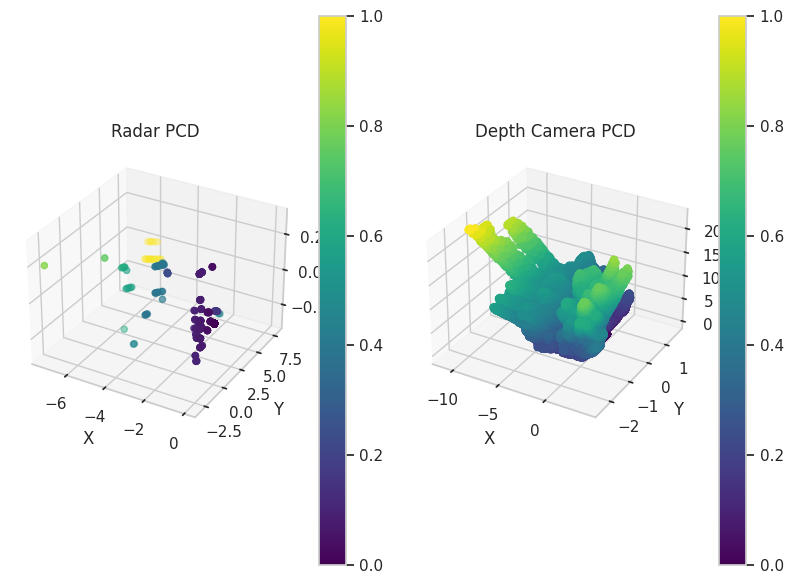

In [21]:
for index, row in tqdm(mergerdPcdDepth.iterrows(), total=len(mergerdPcdDepth), desc="Processing frames"):
    # frameIDX = np.random.randint(0, mergerdPcdDepth.shape[0])
    frameIDX = index
    distancesRadar = np.linalg.norm(mergerdPcdDepth["radarPCD"][frameIDX], axis=1)
    normalized_distances = (distancesRadar - distancesRadar.min()) / (distancesRadar.max() - distancesRadar.min())
    sns.set(style="whitegrid")
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(121,projection='3d')
    distancesRadar = np.linalg.norm(mergerdPcdDepth["radarPCD"][frameIDX], axis=1)
    normalized_distancesRadar = (distancesRadar - distancesRadar.min()) / (distancesRadar.max() - distancesRadar.min())
    img1 = ax1.scatter(mergerdPcdDepth["radarPCD"][frameIDX][:, 0], mergerdPcdDepth["radarPCD"][frameIDX][:, 1], mergerdPcdDepth["radarPCD"][frameIDX][:, 2], c=normalized_distancesRadar,cmap = 'viridis', marker='o')
    fig.colorbar(img1)
    ax1.set_title('Radar PCD')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    ax2 = fig.add_subplot(122,projection='3d')
    distancesDepth = np.linalg.norm(mergerdPcdDepth["depthPCD"][frameIDX], axis=1)
    normalized_distancesDepth = (distancesDepth - distancesDepth.min()) / (distancesDepth.max() - distancesDepth.min())
    img2 = ax2.scatter(mergerdPcdDepth["depthPCD"][frameIDX][:, 0], mergerdPcdDepth["depthPCD"][frameIDX][:, 1], mergerdPcdDepth["depthPCD"][frameIDX][:, 2], c=normalized_distancesDepth, cmap = 'viridis',marker='o')
    fig.colorbar(img2)
    ax2.set_title('Depth Camera PCD')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')
    plt.tight_layout()
    plt.savefig(merRadDepVis + f"radarDepth_{str(frameIDX)}.png")
    # plt.show()
    plt.close()

In [47]:
startProcessingForNewData = True
randomDownSample = False
doDownSampling = True
visulization = False
target_num_points = 3072

In [ ]:
print("Importing Saved Data")
# pointcloudRadarDepth = pd.read_pickle("./mergedRadarDepth.pkl")
pointcloudRadarDepth = mergerdPcdDepth
pointcloudRadarDepth.reset_index(drop=True, inplace=True)

In [ ]:
if doDownSampling:

    pointcloudRadarDepth["sampleDepth"] = None
    if randomDownSample:
        downsample_size = 2000  # Specify the desired downsampled size
        # downsampled_pcd = np.empty((pointcloudRadarDepth.shape[0], downsample_size, 3))
        for index,row in pointcloudRadarDepth.iterrows():
            # print(index)
            indices = np.random.choice(307200, downsample_size, replace=False)  # Random indices
            # pointcloudRadarDepth.loc[index, "sampleDepth"] = pointcloudRadarDepth["depthPCD"].iloc[index][indices].tolist()  # Select points using the random indices
            pointcloudRadarDepth.at[index, "sampleDepth"] = pointcloudRadarDepth["depthPCD"].iloc[index][indices]
    else:
        downsampled_frames = []
        for index,row in pointcloudRadarDepth.iterrows():
            pcd = o3d.geometry.PointCloud()
            print(index)
            voxel_size = 0.05  # Adjust voxel size for desired resolution
            pcd.points = o3d.utility.Vector3dVector(pointcloudRadarDepth["depthPCD"][index])
            #density based downsampling
            

            downsampled_pcd = density_based_downsampling(pcd, target_num_points,voxelSize=0.05)
            downsampled_points = np.asarray(downsampled_pcd.points)
            print("downsampled_points.shape",downsampled_points.shape)
            pointcloudRadarDepth.at[index, "sampleDepth"] = downsampled_points
    pointcloudRadarDepth.to_pickle(processedDataFolder_name + "pointcloudRadarDepth.pkl")
    print("Down Samling Done, pointcloudRadarDepth.pkl Exported")
else:
    pointcloudRadarDepth = pd.read_pickle(processedDataFolder_name + "pointcloudRadarDepth.pkl")
    print("Existing Down Sampled file imported")

In [ ]:
pkl_file = processedDataFolder_name + "mergedRadarDepth.pkl" 

outputDirTrain = processedDataFolder_name + "droneData_Train/processedData/"  
outputDirTest = processedDataFolder_name + "droneData_Test/processedData/"  

txt_file_train = processedDataFolder_name + "droneData_Train/datalist.txt" 
txt_file_test = processedDataFolder_name + "droneData_Test/datalist.txt" 

os.makedirs(outputDirTrain, exist_ok=True)
os.makedirs(outputDirTest, exist_ok=True)

df = pd.read_pickle(pkl_file)
df.reset_index(drop=True, inplace=True)

if not all(col in df.columns for col in ['radarPCD', 'depthPCD', 'datetime']):
    raise ValueError("PKL file must contain 'radarPCD', 'depthPCD', and 'datetime' columns.")


# Split data into train (80%) and test (20%)
train_size = int(0.8 * len(df)) 
indices = np.arange(len(df))
np.random.shuffle(indices)

train_indices = indices[:train_size]
test_indices = indices[train_size:]

with open(txt_file_train, "w") as train_out, open(txt_file_test, "w") as test_out:
    for idx in tqdm(train_indices, desc="Saving Train Data", total=len(train_indices)):
        row = df.iloc[idx]
        mat_file_name = f"{idx + 1}_mmwave.mat"
        mat_file_path = os.path.join(outputDirTrain, mat_file_name)

        savemat(mat_file_path, {
            'radarPCD': row['radarPCD'],
            'depthPCD': row['depthPCD'],
            'datetime': row['datetime']
        })
        train_out.write(mat_file_path + "\n")

    for idx in tqdm(test_indices, desc="Saving Test Data", total=len(test_indices)):
        row = df.iloc[idx]
        mat_file_name = f"{idx + 1}_mmwave.mat"
        mat_file_path = os.path.join(outputDirTest, mat_file_name)

        savemat(mat_file_path, {
            'radarPCD': row['radarPCD'],
            'depthPCD': row['depthPCD'],
            'datetime': row['datetime']
        })
        test_out.write(mat_file_path + "\n")

print(f"Exported {len(train_indices)} train .mat files to '{outputDirTrain}' and recorded in '{txt_file_train}'.")
print(f"Exported {len(test_indices)} test .mat files to '{outputDirTest}' and recorded in '{txt_file_test}'.")


In [ ]:
processedDataFolder_name

In [ ]:
from PIL import Image
import os

# Path to the folder containing images
image_folder = "./datasets/image_data/2025-01-29_12_41_45"
output_gif = "outputRadar.gif"

# Get list of image files (sorted by filename)
image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(('.png', '.jpg', '.jpeg'))])

# Load images
images = [Image.open(os.path.join(image_folder, img)) for img in image_files]

# Save as GIF
images[0].save(
    output_gif,
    save_all=True,
    append_images=images[1:],  # Append the rest of the images
    duration=.001,  # Duration per frame in milliseconds (adjust as needed)
    loop=0  # Loop indefinitely
)

print(f"GIF saved as {output_gif}")
